In [476]:
# can we build more efficient clusters through auto-encoders rather than PCA?

In [477]:
import tensorflow as tf

In [478]:
tf.config.get_visible_devices(
    device_type=None
)[0]

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')

In [479]:
tf.config.set_visible_devices(tf.config.get_visible_devices(
    device_type=None
)[0])

In [480]:
import matplotlib.pyplot as plt
plt.figure()
plt.show()
plt.close()
plt.rcParams.update({'font.size':16})

<Figure size 640x480 with 0 Axes>

In [481]:
import phenom

In [482]:
import pycbc.waveform
import numpy as np
import sklearn.cluster
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
import sklearn.decomposition
import sklearn.mixture

In [483]:
# so we can specify minimum cluster size
from k_means_constrained import KMeansConstrained

In [484]:
import corner

In [485]:
n_samples = 1000
# n_samples = 5000
# n_samples = 10000
mtot = 100
qs = np.random.uniform(1, 100, n_samples)
etas = phenom.eta_from_q(qs)
# chieffs = np.random.uniform(-1, 1, n_samples)
chi1s = np.random.uniform(-1, 1, n_samples)
chi2s = np.random.uniform(-1, 1, n_samples)
m1s, m2s = phenom.m1_m2_M_q(mtot, qs)
cos_inc = np.random.uniform(-1, 1, n_samples)
incs = np.arccos( cos_inc )

In [486]:
# X = np.c_[qs, chi1s, incs]
# feature_names = ['q', 'chi1', 'inc']

# X = np.c_[etas, chi1s, incs]
# feature_names = ['eta', 'chi1', 'inc']



# X = np.c_[qs, chi1s, chi2s]
# feature_names = ['q', 'chi1', 'chi2']

X = np.c_[etas, chi1s, chi2s]
feature_names = ['eta', 'chi1', 'chi2']

# X = np.c_[etas, chi1s, chi2s, incs]
# feature_names = ['eta', 'chi1', 'chi2', 'inc']

In [487]:
def get_amp(q, chi1, chi2, times, approximant, mtotal=100, f_lower=20, delta_t=1/2048., distance=1e-18, inc=0):
    mass1, mass2 = phenom.m1_m2_M_q(mtotal, q)
    spin1z=chi1
    spin2z=chi2
    kwargs=dict(
        approximant=approximant,
        mass1=mass1,
        mass2=mass2,
        f_lower=f_lower,
        delta_t=delta_t,
        spin1z=spin1z,
        spin2z=spin2z,
        inclination=inc,
        distance=distance
    )
    hp, hc = pycbc.waveform.get_td_waveform(**kwargs)
    amp = pycbc.waveform.utils.amplitude_from_polarizations(hp, hc)
    # phase = pycbc.waveform.utils.phase_from_polarizations(hp, hc)
    # freq = pycbc.waveform.utils.frequency_from_polarizations(hp, hc)
    # amp = phase
    # amp = hp


    # resample
    new_amp = IUS(amp.sample_times, amp.numpy())(times)
    
    new_amp = new_amp / phenom.eta_from_q(q)

    return new_amp


In [488]:
start_time=-0.16
end_time=0.05
times = np.linspace(start_time, end_time, 500)

In [489]:
%%time
# approximant='IMRPhenomTPHM'
approximant='SEOBNRv4_opt'
amps=[]
for i in range(len(X)):
    q=phenom.q_from_eta(X[i,0])
    chi1=X[i,1]
    chi2=X[i,2]
    # inc=X[i,2]
    inc=0
    # chi2=0
    amps.append(get_amp(q,chi1, chi2=chi2, times=times, approximant=approximant, inc=inc))

CPU times: user 16.7 s, sys: 4.67 s, total: 21.3 s
Wall time: 21.6 s


In [490]:
new_amps = amps.copy()

In [491]:
new_amps = np.array(new_amps)

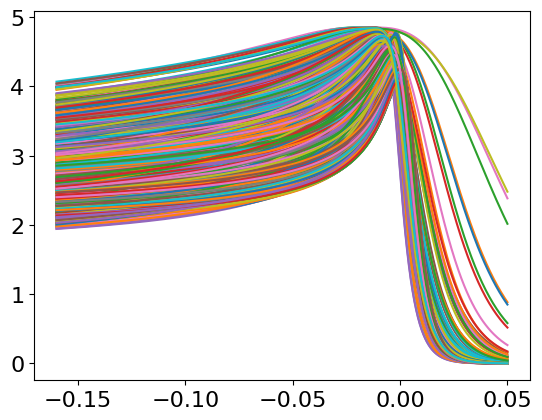

In [492]:
for y in new_amps:
    plt.plot(times, y)

In [493]:
standard_scaler = sklearn.preprocessing.StandardScaler()

In [494]:
new_amps = standard_scaler.fit_transform(new_amps)

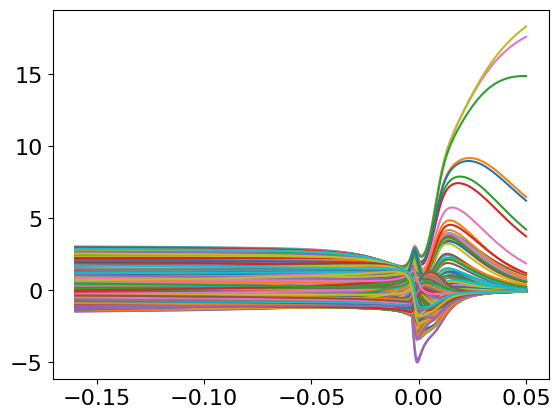

In [495]:
for y in new_amps:
    plt.plot(times, y)

In [496]:
minmax_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1,1))

In [497]:
times_prime = minmax_scaler.fit_transform(times[:,None])[:,0]

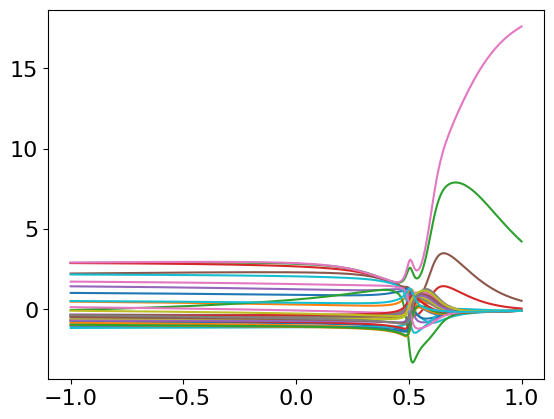

In [498]:
for y in new_amps[:30]:
    plt.plot(times_prime, y)

# pca

In [499]:
# n_components=2
# n_components=5
# n_components=16
n_components=50 # for this initial embedding we don't need to use a truncated basis
pca = sklearn.decomposition.PCA(n_components=n_components)
pca.fit(new_amps)
pca_coeffs = pca.transform(new_amps)

In [500]:
pca.explained_variance_ratio_.sum()

0.9999999999311983

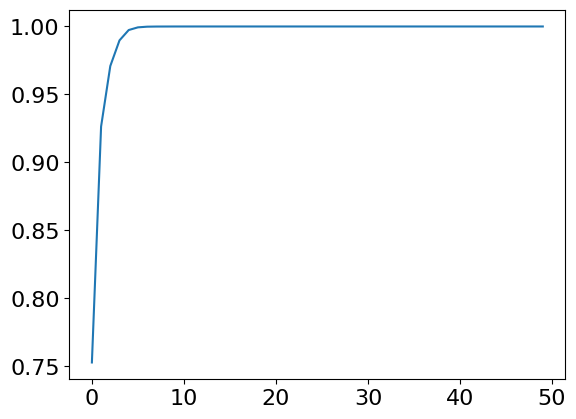

In [501]:
plt.plot(pca.explained_variance_ratio_.cumsum())

In [502]:
pca_yhat = np.dot(pca_coeffs, pca.components_)

In [503]:
pca_yhat.shape

(1000, 500)

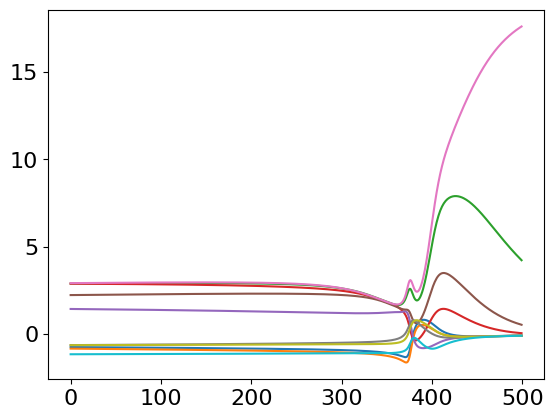

In [504]:
plt.plot(pca_yhat[:10].T);

In [505]:
pca_error = np.mean(np.square(new_amps - pca_yhat), 1)

Text(0.5, 1.0, 'reconstruction error')

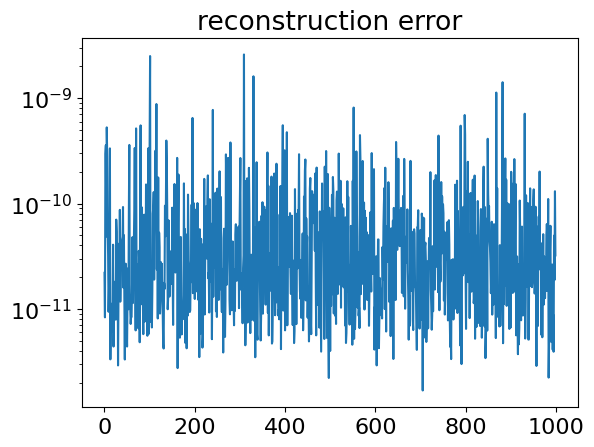

In [506]:
plt.plot(pca_error)
plt.yscale('log')
plt.title('reconstruction error')

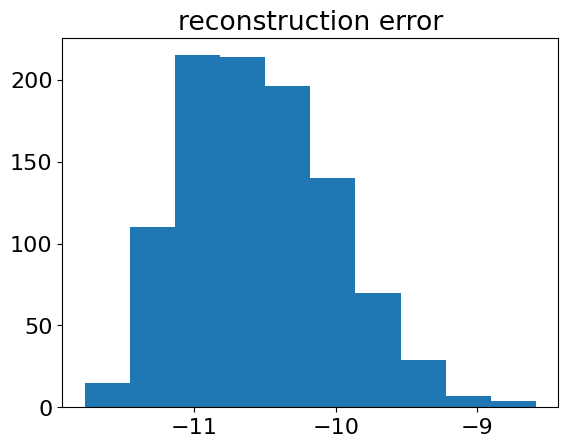

In [507]:
plt.title('reconstruction error')
plt.hist(np.log10(pca_error));

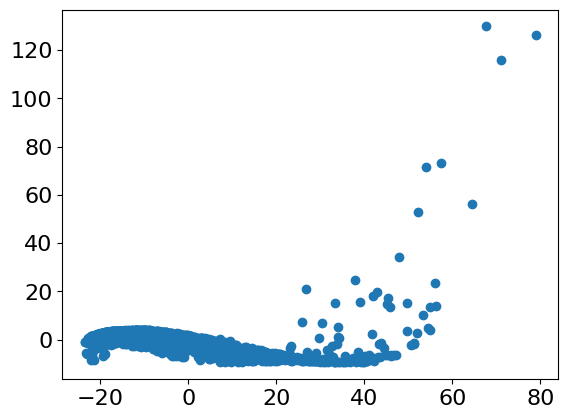

In [508]:
plt.scatter(pca_coeffs[:,0], pca_coeffs[:,1])

In [509]:
kmeans_pca = sklearn.cluster.KMeans(n_clusters=3, n_init='auto').fit(pca_coeffs)

In [510]:
np.bincount(kmeans_pca.labels_)

array([330, 663,   7])

In [511]:
pca_u_labels = np.unique(kmeans_pca.labels_)

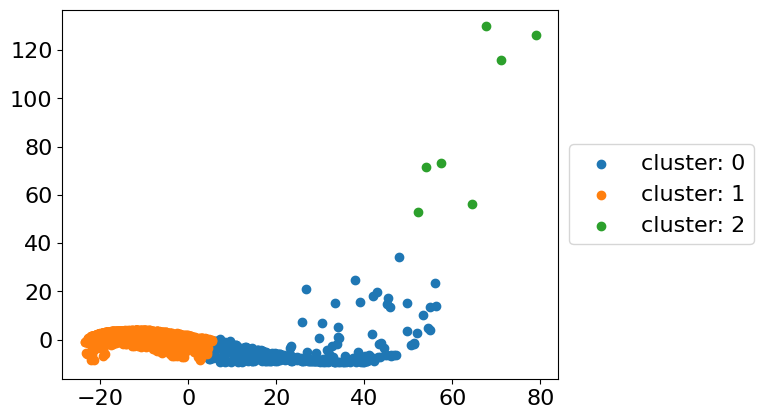

In [512]:
for i, u_label in enumerate(pca_u_labels):
    plt.scatter(pca_coeffs[kmeans_pca.labels_==u_label,0], pca_coeffs[kmeans_pca.labels_==u_label,1], c=f"C{i}", label=f'cluster: {i}')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

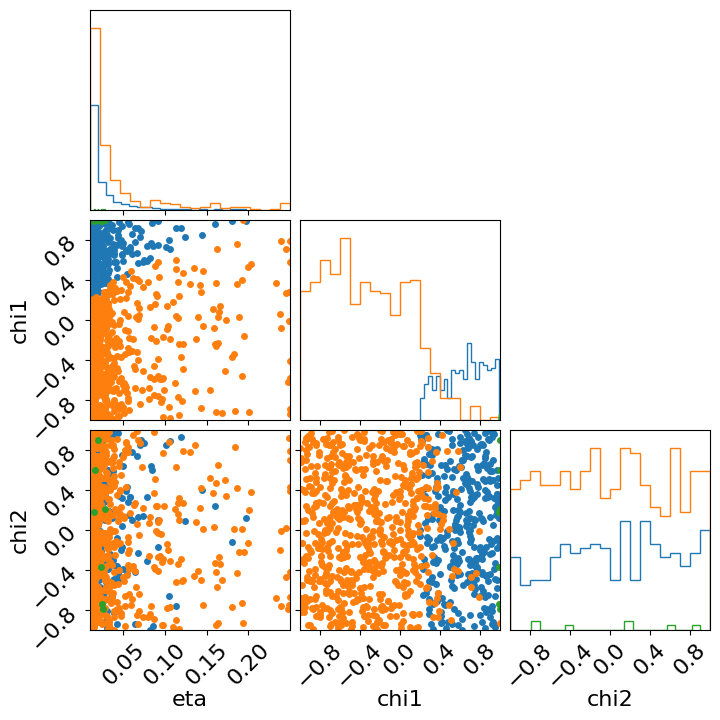

In [513]:
fig = corner.corner(X[kmeans_pca.labels_==pca_u_labels[0]], color='C0', labels=feature_names, plot_contours=False, plot_density=False, data_kwargs={'ms':5, 'alpha':1});
for i, u_label in enumerate(pca_u_labels[1:]):
    corner.corner(X[kmeans_pca.labels_==u_label], color=f'C{i+1}', fig=fig, plot_contours=False, plot_density=False, data_kwargs={'ms':5, 'alpha':1});

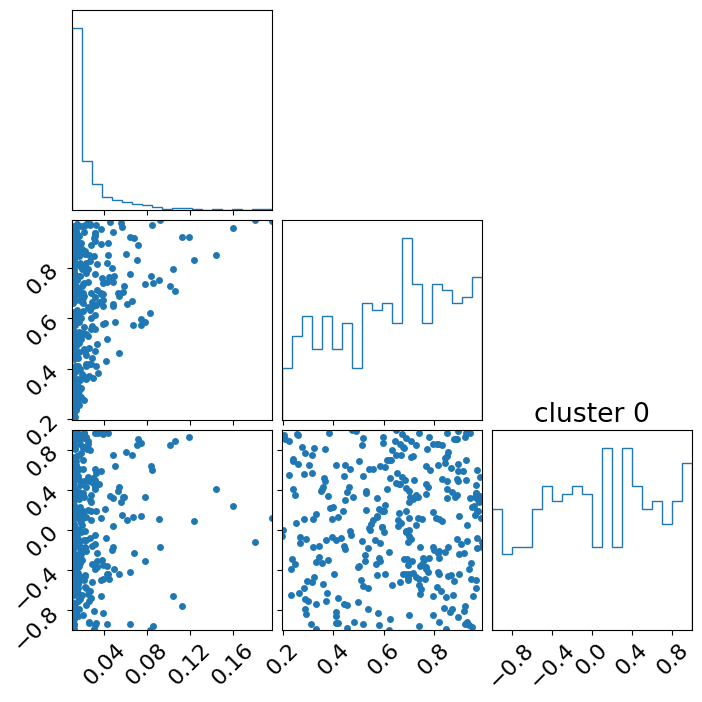

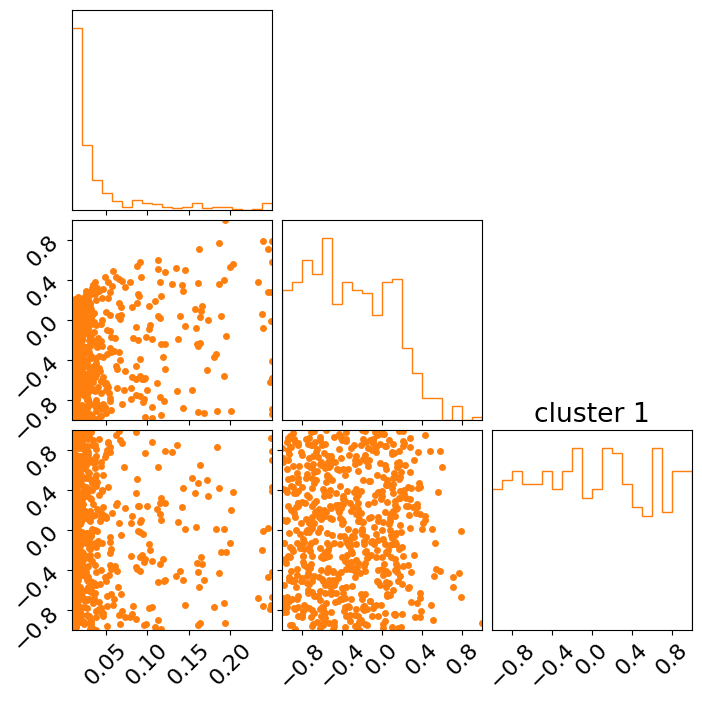

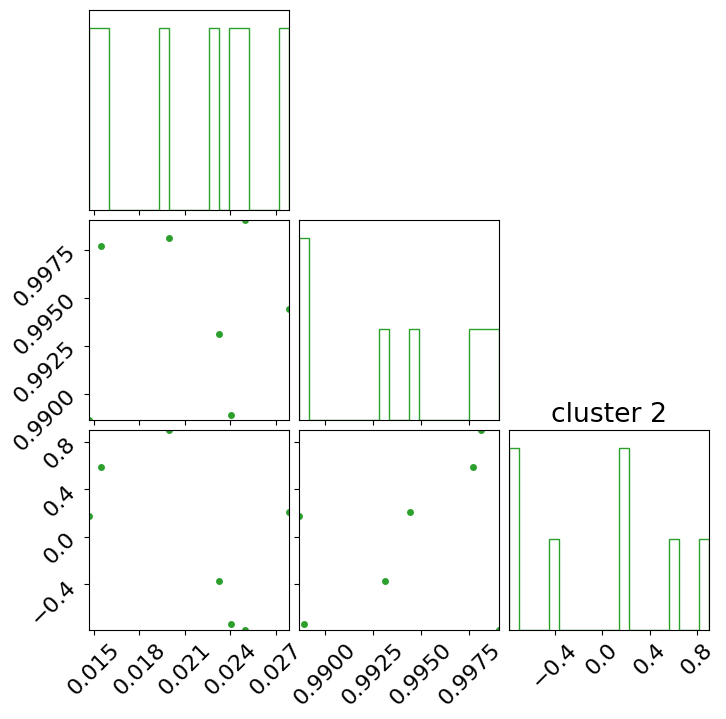

In [514]:
for i, u_label in enumerate(pca_u_labels):
    corner.corner(X[kmeans_pca.labels_==u_label], color=f'C{i}', plot_contours=False, plot_density=False, data_kwargs={'ms':5, 'alpha':1});
    plt.title(f'cluster {i}')
    plt.show()
    plt.close()

# auto encoder

In [515]:
new_amps.shape

(1000, 500)

In [516]:
input_shape = new_amps.shape[1]
output_shape = input_shape

# latent_dim = 2
latent_dim = 5
# latent_dim = 16
# latent_dim = 1024
# latent_dim = 32

# trade-off between latent dim and computational cost / meaning of clustering in high dim space.
# higher dim means it's more difficult to define meaningful distances?

activation='relu'
# activation='leaky_relu'
# activation='tanh'
# activation='elu'
# activation='swish'
# activation='linear'

latent_activation = 'tanh'
# latent_activation = 'linear'
# latent_activation = 'relu'
# latent_activation = 'elu'

# B_scale_0 = 100
# kernel_initializer_0 = tf.keras.initializers.RandomNormal(mean=0., stddev=B_scale_0)
# bias_initializer_0 = tf.keras.initializers.RandomUniform(minval=-1., maxval=1.)


model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape),
    # tf.keras.layers.Dense(512, kernel_initializer=kernel_initializer_0, bias_initializer=bias_initializer_0, trainable=False),
    # tf.keras.layers.Lambda(lambda x: tf.math.sin(np.pi*x)),
    # tf.keras.layers.experimental.RandomFourierFeatures(output_dim=4096, scale=1., kernel_initializer='gaussian'),
    tf.keras.layers.Dense(256, activation=activation),
    tf.keras.layers.Dense(256, activation=activation),
    # tf.keras.layers.Dense(256, activation=activation),
    # tf.keras.layers.Dense(128, activation=activation),
    # tf.keras.layers.Dense(32, activation=activation),
    # tf.keras.layers.Dense(16, activation=activation),
    tf.keras.layers.Dense(latent_dim, activation=latent_activation, name='latent'),
    # tf.keras.layers.Dense(16, activation=activation),
    # tf.keras.layers.Dense(32, activation=activation),
    # tf.keras.layers.Dense(128, activation=activation),
    # tf.keras.layers.Dense(256, activation=activation),
    tf.keras.layers.Dense(256, activation=activation),
    tf.keras.layers.Dense(256, activation=activation),
    # tf.keras.layers.experimental.RandomFourierFeatures(output_dim=4096, scale=10., kernel_initializer='gaussian'),
    tf.keras.layers.Dense(output_shape),
])
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')
# model.predict(np.random.normal(0, 1, size=(1,3)))

In [517]:
%%time
history = model.fit(new_amps, new_amps, epochs=100, verbose=0, batch_size=32, validation_split=0.2)

CPU times: user 13.7 s, sys: 4.24 s, total: 17.9 s
Wall time: 10.2 s


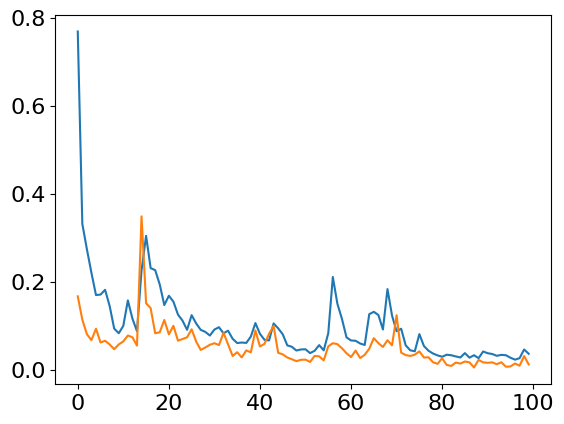

In [518]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

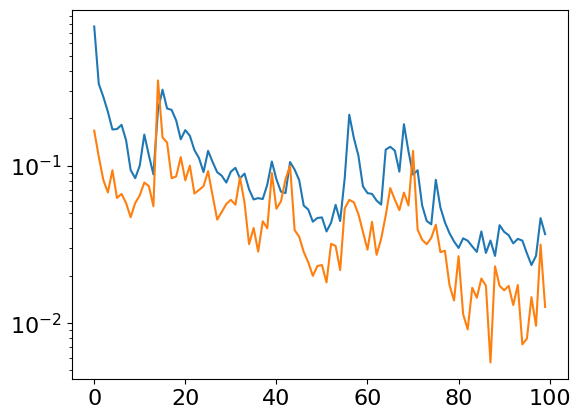

In [519]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')

In [520]:
encoder = tf.keras.Model(model.input, model.get_layer('latent').output)
ae_coeffs = encoder.predict(new_amps, verbose=0)  # bottleneck representation
yhat_ae = model.predict(new_amps, verbose=0)        # reconstruction

In [521]:
ae_coeffs.shape

(1000, 5)

In [522]:
yhat_ae.shape

(1000, 500)

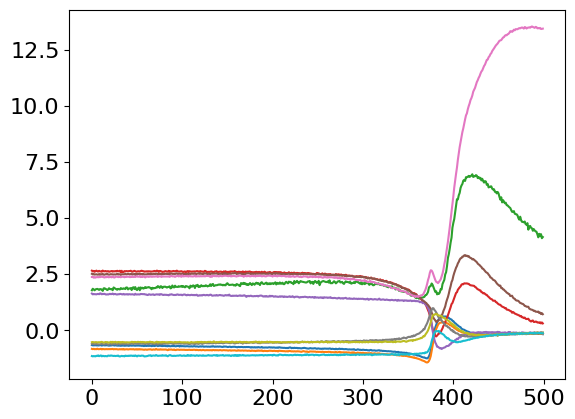

In [523]:
plt.plot(yhat_ae[:10].T);

In [524]:
ae_error = np.mean(np.square(new_amps - yhat_ae), 1)

Text(0.5, 1.0, 'reconstruction error')

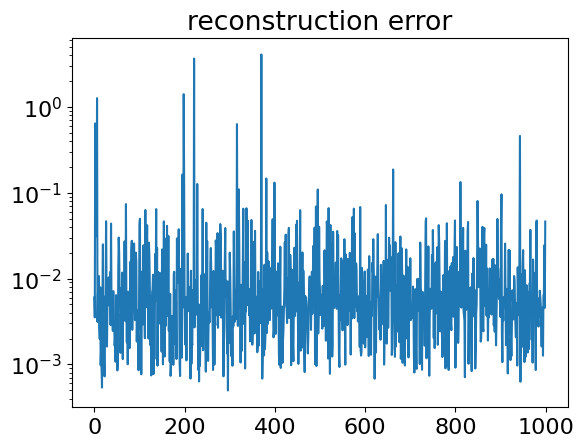

In [525]:
plt.plot(ae_error)
plt.yscale('log')
plt.title('reconstruction error')

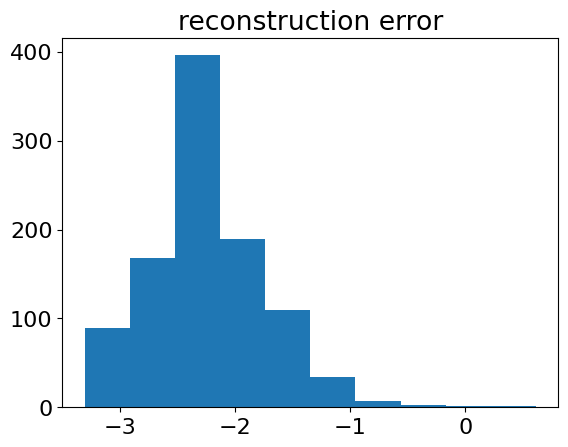

In [526]:
plt.title('reconstruction error')
plt.hist(np.log10(ae_error));

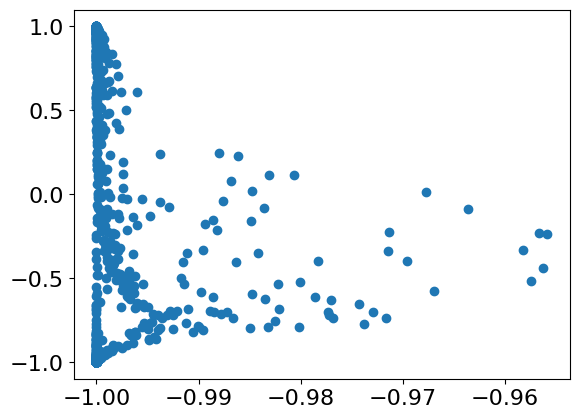

In [527]:
plt.scatter(ae_coeffs[:,0], ae_coeffs[:,1])

In [528]:
kmeans_ae = sklearn.cluster.KMeans(n_clusters=5, n_init='auto').fit(ae_coeffs)

In [529]:
np.bincount(kmeans_ae.labels_)

array([240,  99, 192, 376,  93])

In [530]:
u_labels = np.unique(kmeans_ae.labels_)

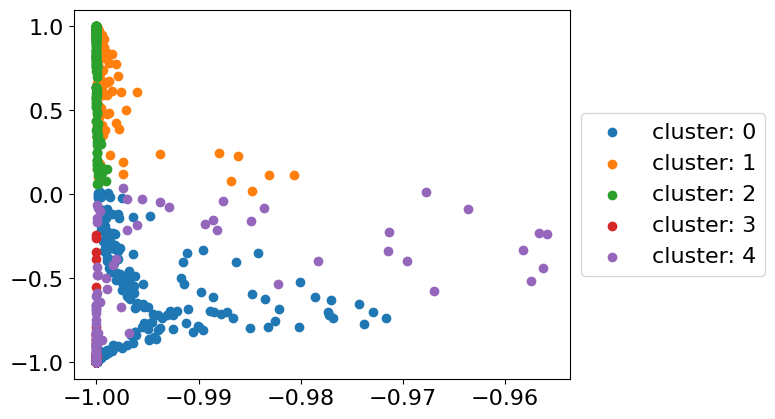

In [531]:
for i, u_label in enumerate(u_labels):
    plt.scatter(ae_coeffs[kmeans_ae.labels_==u_label,0], ae_coeffs[kmeans_ae.labels_==u_label,1], c=f"C{i}", label=f'cluster: {i}')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

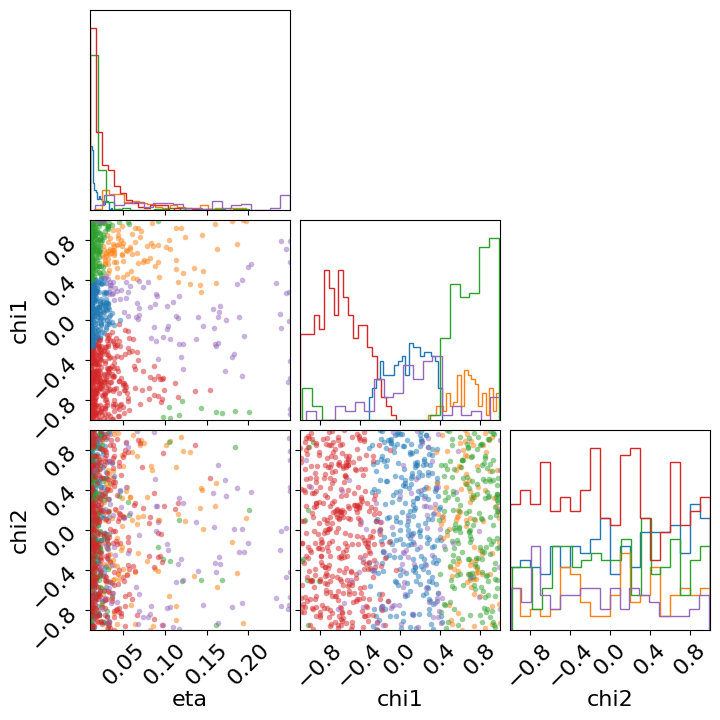

In [532]:
fig = corner.corner(X[kmeans_ae.labels_==u_labels[0]], color='C0', labels=feature_names, plot_contours=False, plot_density=False, data_kwargs={'ms':4, 'alpha':0.5});
for i, u_label in enumerate(u_labels[1:]):
    corner.corner(X[kmeans_ae.labels_==u_label], color=f'C{i+1}', fig=fig, plot_contours=False, plot_density=False, data_kwargs={'ms':4, 'alpha':0.5});

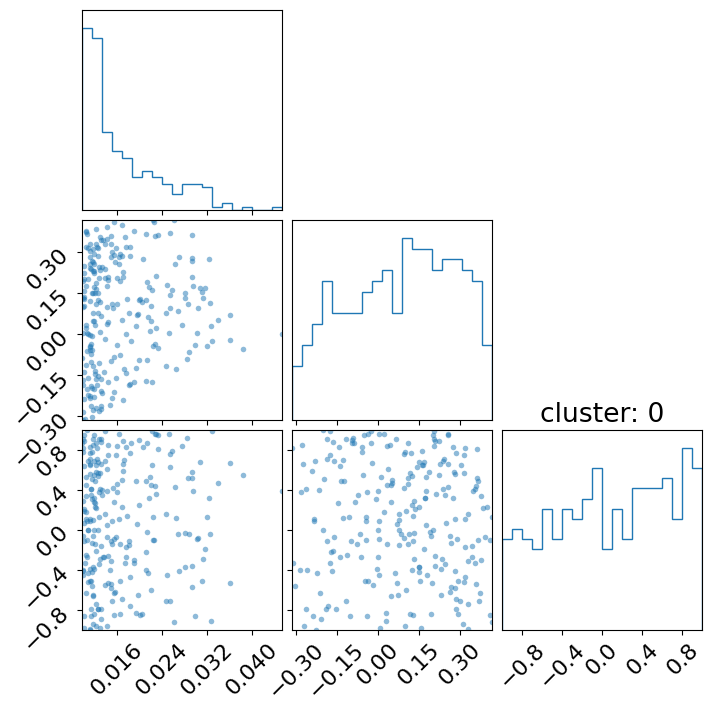

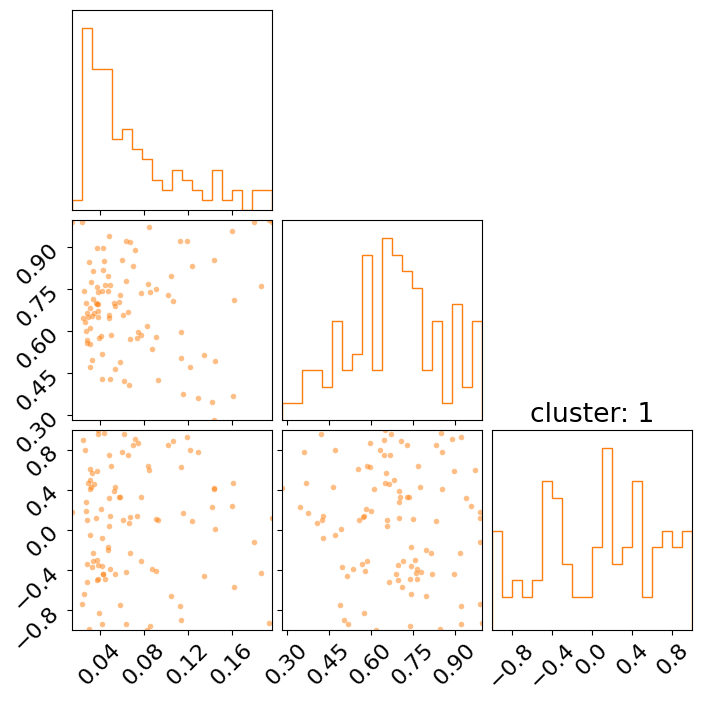

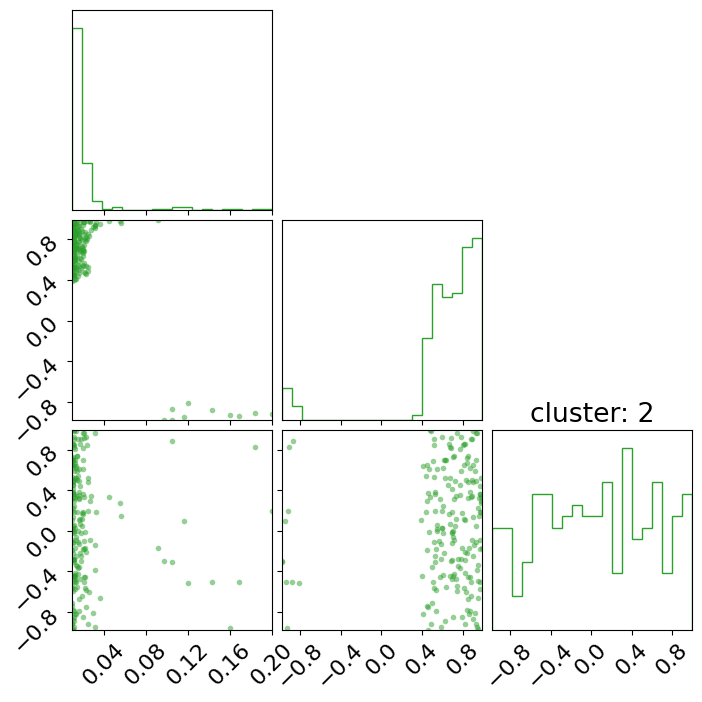

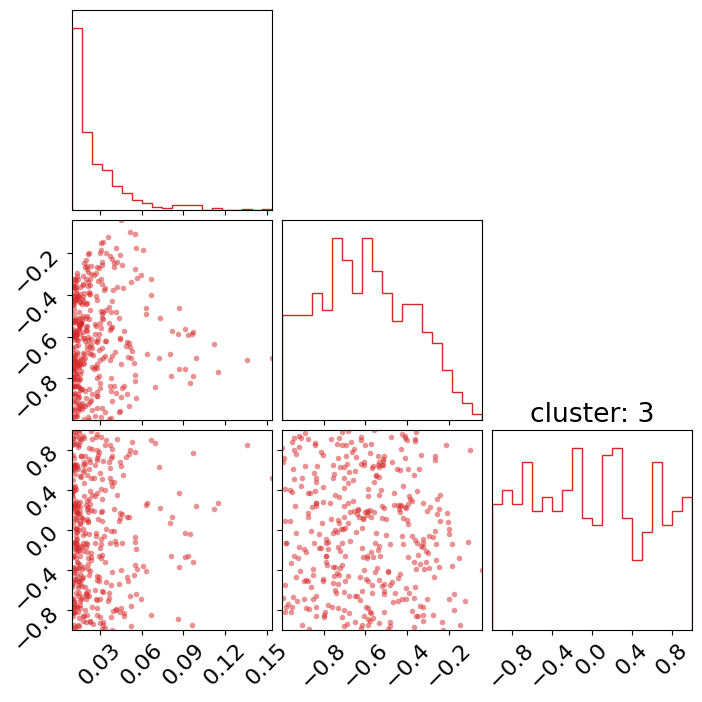

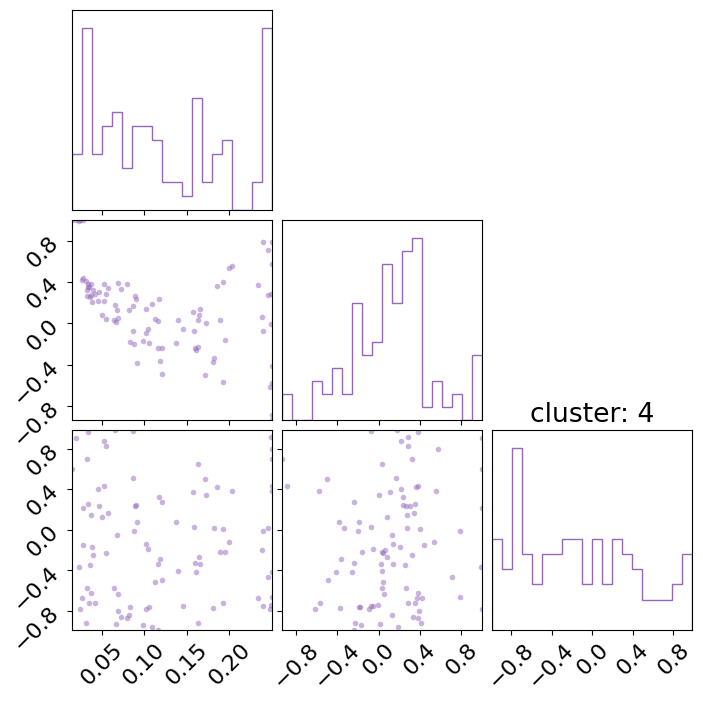

In [533]:
for i, u_label in enumerate(u_labels):
    corner.corner(X[kmeans_ae.labels_==u_label], color=f'C{i}', plot_contours=False, plot_density=False, data_kwargs={'ms':4, 'alpha':0.5});
    plt.title(f'cluster: {i}')
    plt.show()
    plt.close()

# comparison

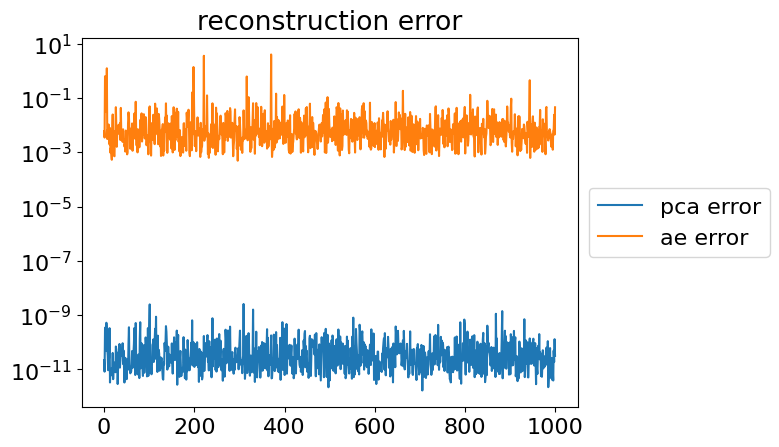

In [534]:
plt.plot(pca_error, label='pca error')
plt.plot(ae_error, label='ae error')
plt.yscale('log')
plt.title('reconstruction error')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

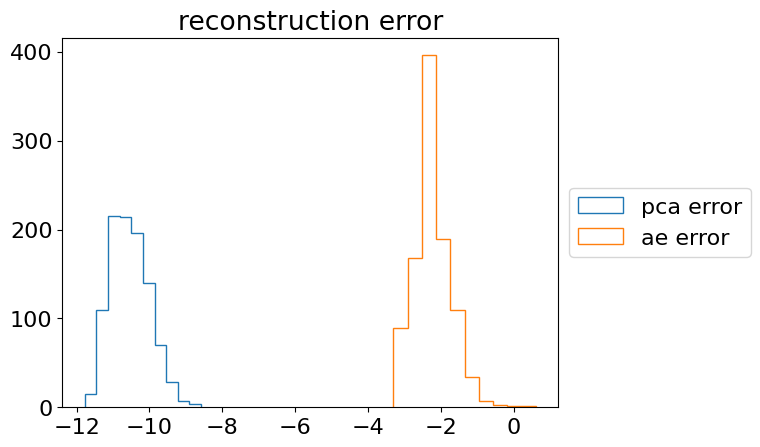

In [535]:
plt.title('reconstruction error')
plt.hist(np.log10(pca_error), label='pca error', histtype='step');
plt.hist(np.log10(ae_error), label='ae error', histtype='step');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

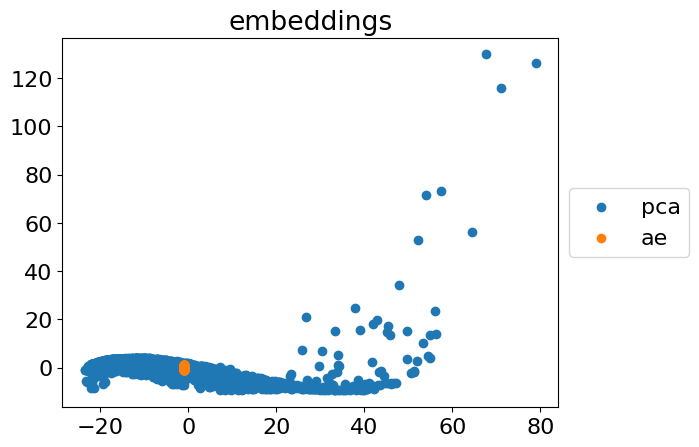

In [536]:
plt.title('embeddings')
plt.scatter(pca_coeffs[:,0], pca_coeffs[:,1], label='pca')
plt.scatter(ae_coeffs[:,0], ae_coeffs[:,1], label='ae')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

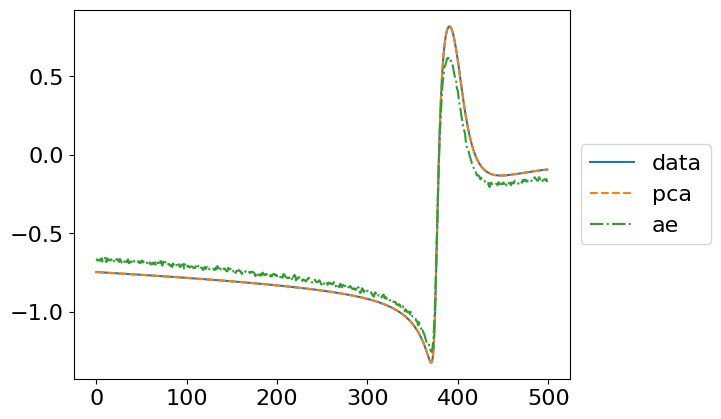

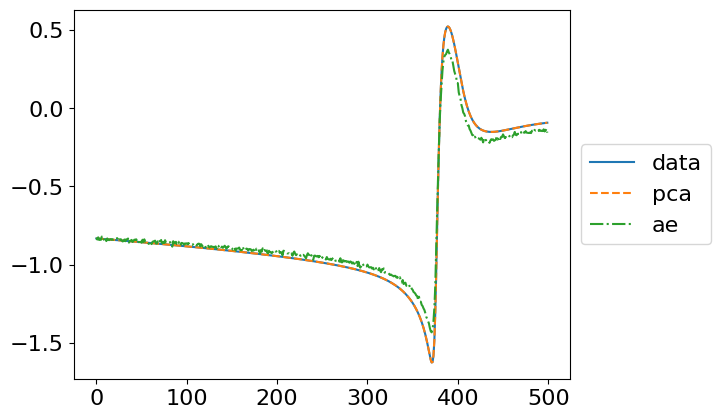

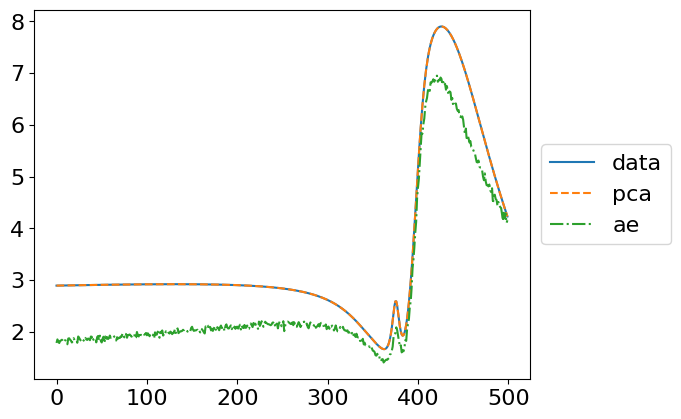

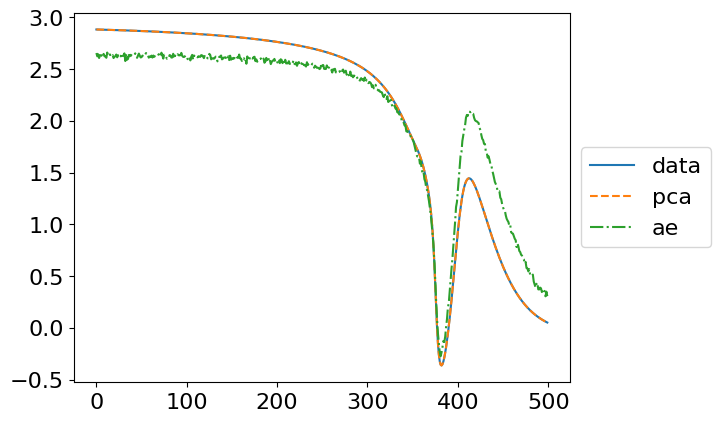

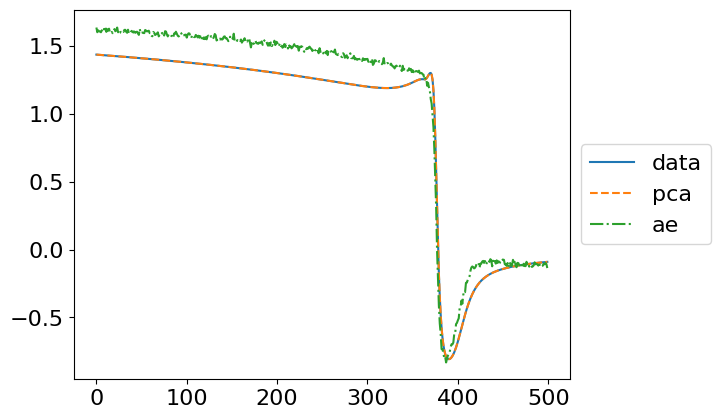

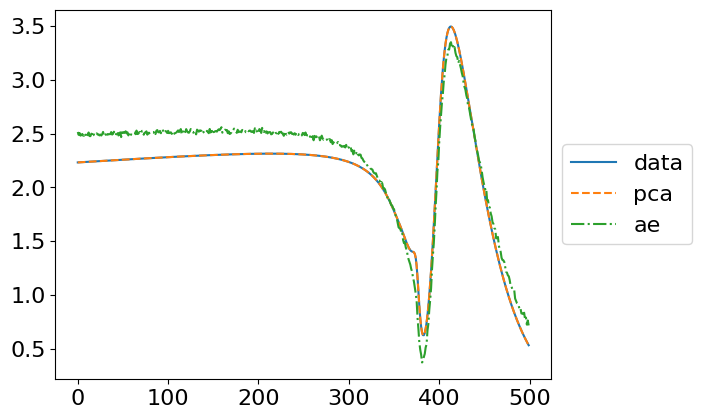

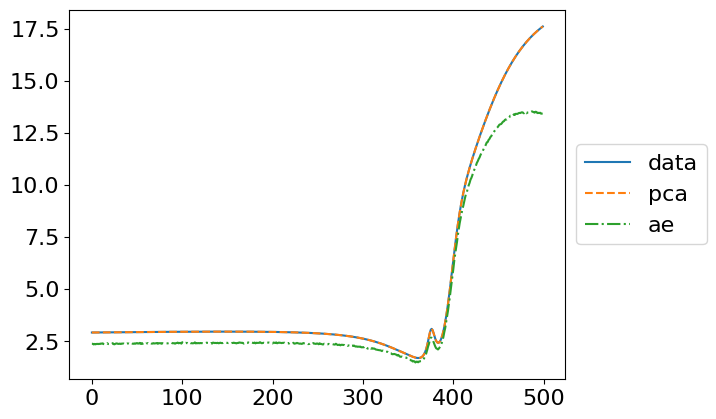

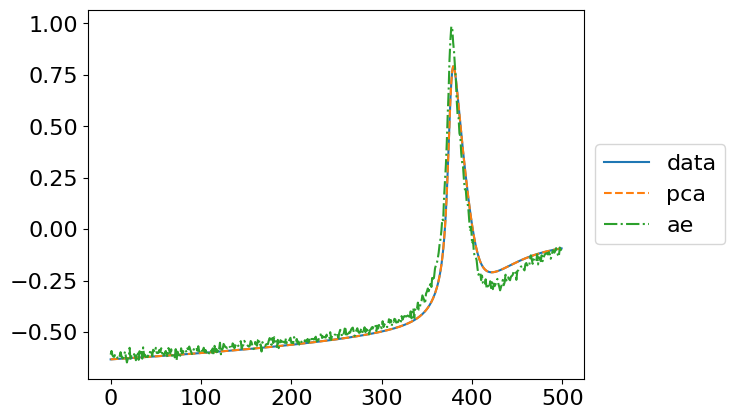

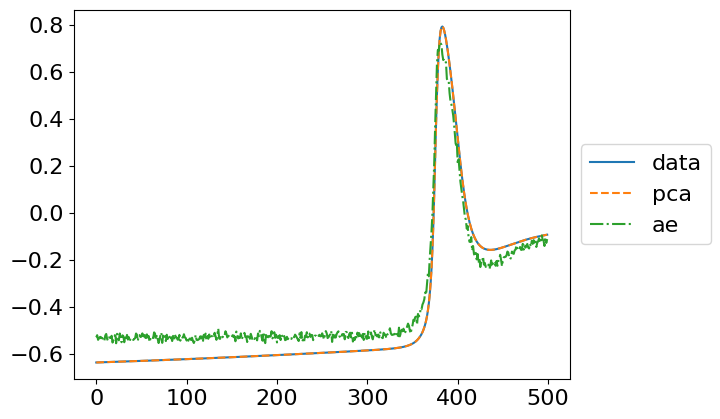

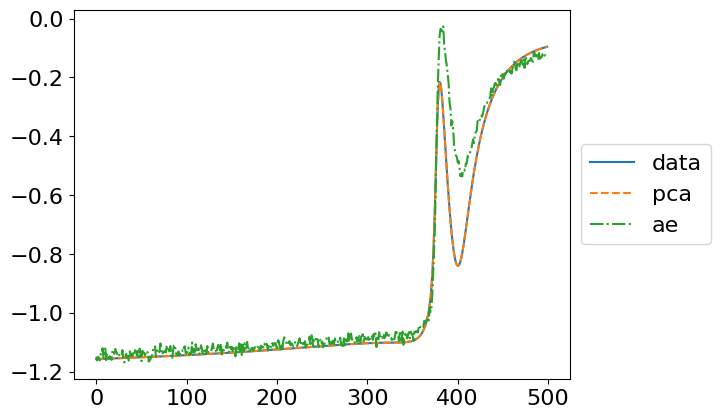

In [537]:
for i in range(10):
    plt.figure()
    plt.plot(new_amps[i], label='data')
    plt.plot(pca_yhat[i], ls='--', label='pca')
    plt.plot(yhat_ae[i], ls='-.', label='ae');
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    plt.close()

# quality of clusters

If clusters are good then it will contain waveforms that are similar.

## random samples from each cluster

### pca

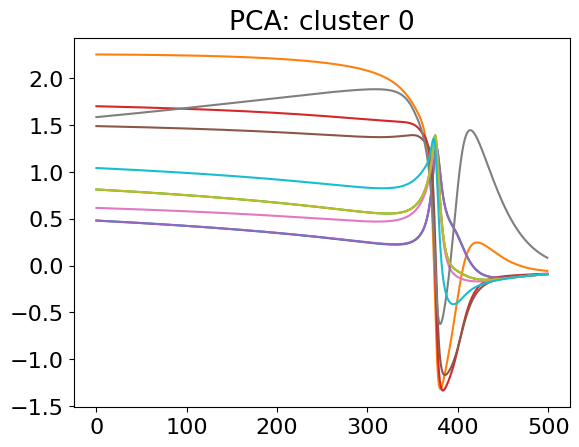

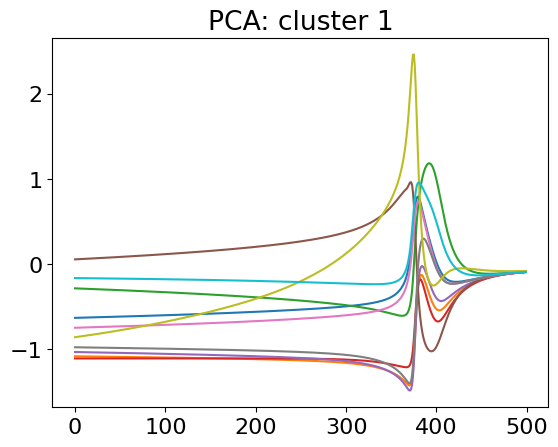

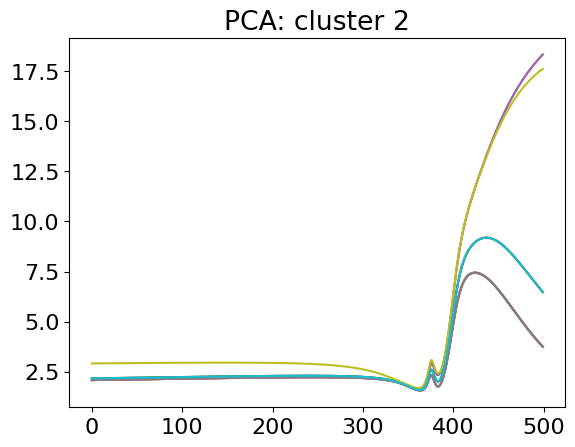

In [538]:
for i, u_label in enumerate(pca_u_labels):
    plt.figure()
    subset=new_amps[kmeans_pca.labels_==u_label]
    idxs = np.random.choice(np.arange(len(subset)), 10)
    plt.plot(subset[idxs].T)
    plt.title(f'PCA: cluster {i}')
    plt.show()
    plt.close()

### autoencoder

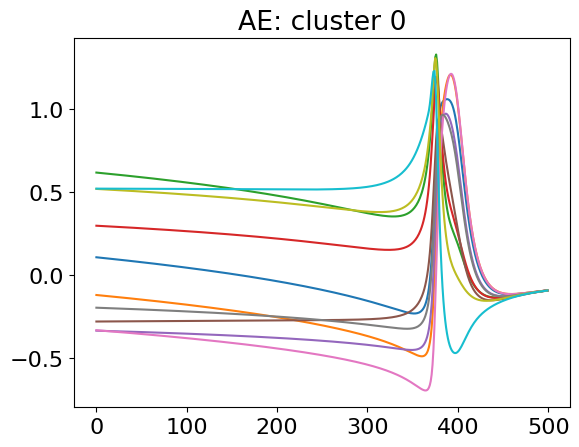

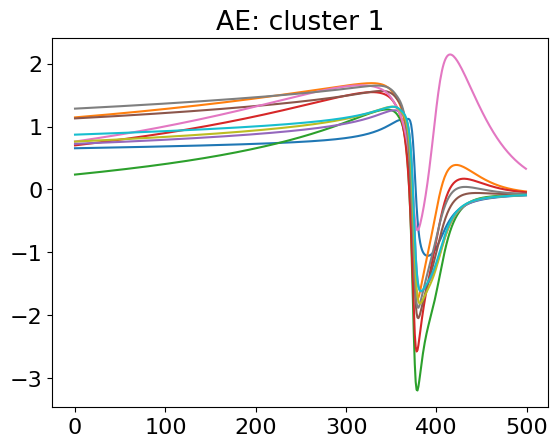

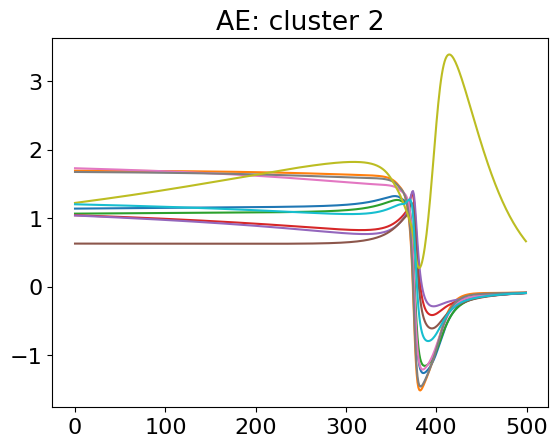

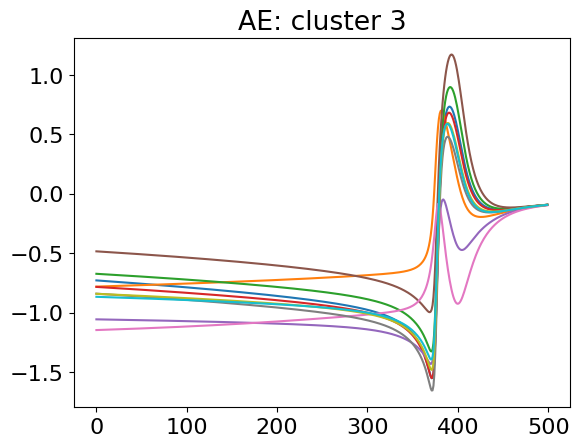

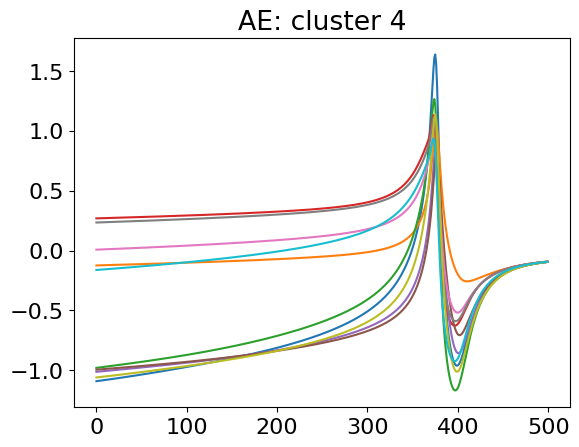

In [539]:
for i, u_label in enumerate(u_labels):
    plt.figure()
    # subset=yhat_ae[kmeans_ae.labels_==u_label]
    subset=new_amps[kmeans_ae.labels_==u_label]
    idxs = np.random.choice(np.arange(len(subset)), 10)
    plt.plot(subset[idxs].T)
    plt.title(f'AE: cluster {i}')
    plt.show()
    plt.close()

## mean and variance of each cluster

In [540]:
pca_stds=[]
for i, u_label in enumerate(pca_u_labels):
    subset=new_amps[kmeans_pca.labels_==u_label]
    pca_stds.append(subset.std(0).mean())
pca_stds = np.array(pca_stds)

In [541]:
pca_stds

array([0.66554168, 0.40398205, 0.87731773])

In [542]:
ae_stds=[]
for i, u_label in enumerate(u_labels):
    subset=new_amps[kmeans_ae.labels_==u_label]
    ae_stds.append(subset.std(0).mean())
ae_stds = np.array(ae_stds)

In [543]:
ae_stds

array([0.27960124, 0.6307525 , 0.80102975, 0.21620536, 1.15105231])

# compute a new PCA for the waveforms in each cluster

## pca

In [763]:
pca_u_labels

array([0, 1, 2], dtype=int32)

In [764]:
u_label = pca_u_labels[0]
subset=new_amps[kmeans_pca.labels_==u_label]

# make normal data
subset = standard_scaler.inverse_transform(subset)




In [765]:
subset.shape

(330, 500)

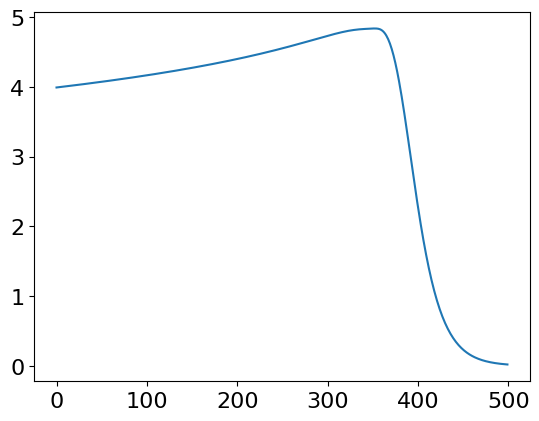

In [766]:
plt.plot(subset[0])

In [767]:
new_standard_scaler = sklearn.preprocessing.StandardScaler()

In [768]:
new_new_amps = new_standard_scaler.fit_transform(subset)

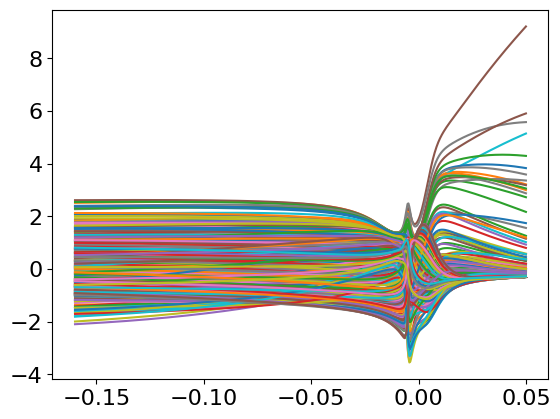

In [769]:
for y in new_new_amps:
    plt.plot(times, y)

In [770]:
# n_components=3
# n_components=4
# n_components=6
n_components=7
# n_components=16
# n_components=32
new_pca = sklearn.decomposition.PCA(n_components=n_components)
new_pca.fit(new_new_amps)
new_pca_coeffs = new_pca.transform(new_new_amps)

In [771]:
new_pca.explained_variance_ratio_.cumsum()

array([0.76054133, 0.923996  , 0.98599357, 0.99675815, 0.99955955,
       0.99982563, 0.99993922])

In [772]:
new_pca.explained_variance_ratio_.sum()

0.9999392248789085

In [773]:
new_pca_coeffs.shape

(330, 7)

In [774]:
new_pca_yhat = np.dot(new_pca_coeffs, new_pca.components_)

In [775]:
new_pca_yhat.shape

(330, 500)

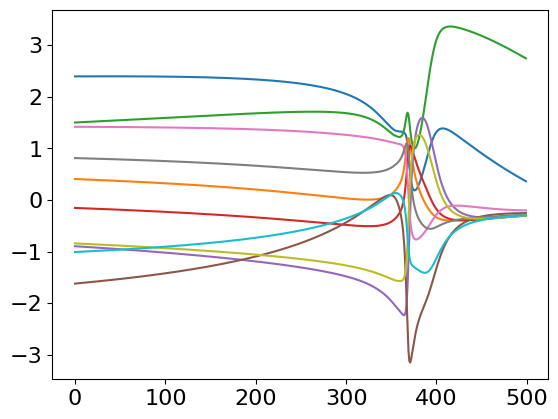

In [776]:
plt.plot(new_pca_yhat[:10].T);

In [777]:
new_pca_error = np.mean(np.square(new_new_amps - new_pca_yhat), 1)

Text(0.5, 1.0, 'reconstruction error')

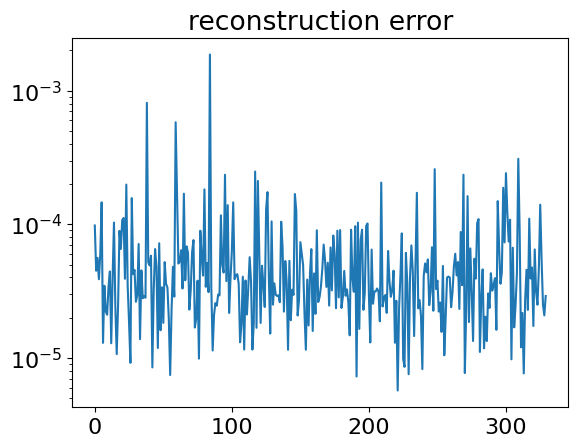

In [778]:
plt.plot(new_pca_error)
plt.yscale('log')
plt.title('reconstruction error')

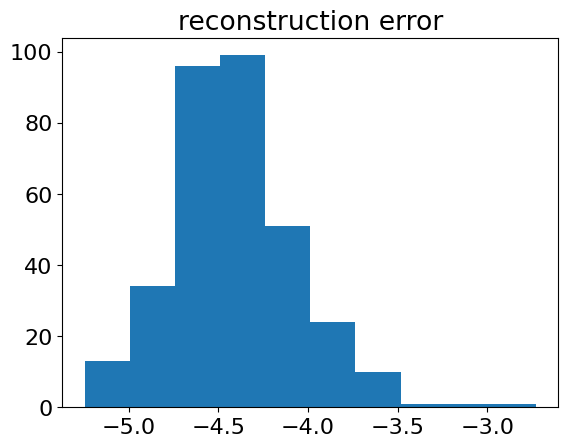

In [779]:
plt.title('reconstruction error')
plt.hist(np.log10(new_pca_error));

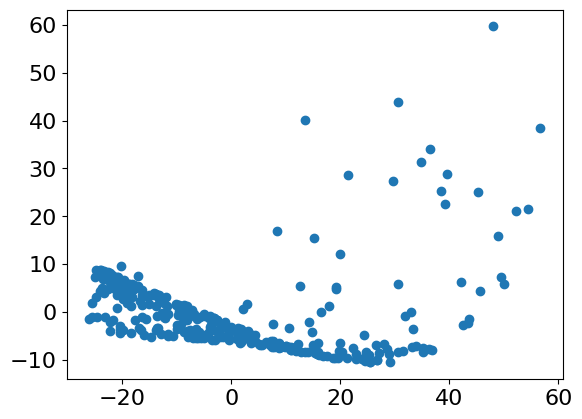

In [780]:
plt.scatter(new_pca_coeffs[:,0], new_pca_coeffs[:,1])

In [781]:
new_kmeans_pca = sklearn.cluster.KMeans(n_clusters=6, n_init='auto').fit(new_pca_coeffs)

In [782]:
np.bincount(new_kmeans_pca.labels_)

array([93, 90,  2, 39, 91, 15])

In [783]:
new_pca_u_labels = np.unique(new_kmeans_pca.labels_)

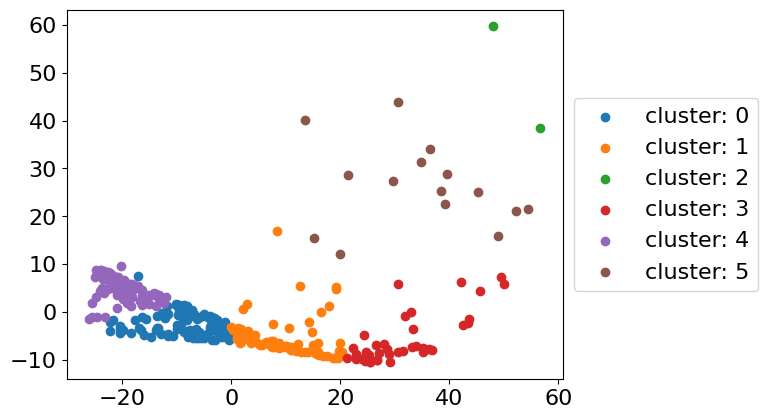

In [784]:
for i, u_label in enumerate(new_pca_u_labels):
    plt.scatter(new_pca_coeffs[new_kmeans_pca.labels_==u_label,0], new_pca_coeffs[new_kmeans_pca.labels_==u_label,1], c=f"C{i}", label=f'cluster: {i}')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Text(0.5, 1.0, 'idx: 89')

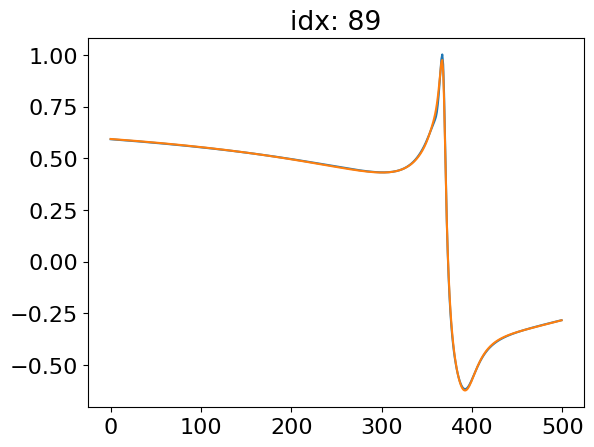

In [785]:
idx = np.random.choice(range(len(new_new_amps)))
plt.plot(new_new_amps[idx])
plt.plot(new_pca_yhat[idx]);
plt.title(f"idx: {idx}")

Text(0.5, 1.0, 'idx: 89')

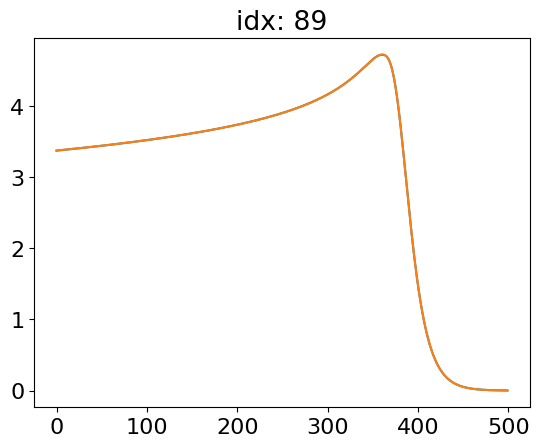

In [786]:
y_true = new_standard_scaler.inverse_transform(new_new_amps[idx][np.newaxis,:])[0]
y_pred = new_standard_scaler.inverse_transform(new_pca_yhat[idx][np.newaxis,:])[0]
plt.plot(y_true)
plt.plot(y_pred)
plt.title(f"idx: {idx}")

Text(0.5, 1.0, 'idx: 89')

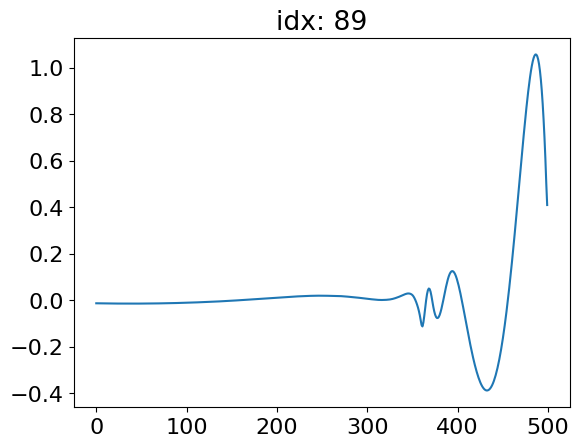

In [787]:
plt.plot((y_true-y_pred)/y_pred * 100)
plt.title(f"idx: {idx}")